In [55]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools

In [56]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [57]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [58]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [59]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.3}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in [1, -1]:
            positive_stark_shift = (label * positive_field_plate) > 0
            if positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [60]:
def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        raise NotImplementedError()
    return (heights, backgrounds)

In [61]:
def ah_parameters_from_data1(data_number):
    data, headers = get_experiment_data(data_number)
    cycles = headers["params"]["detect"]["cycles"]
    total_cycles = sum(cycles.values())
    remainder_to_label = {}
    for kk in range(total_cycles):
        last_index_of_label = 0
        for label in cycles:
            if cycles[label] > 0:
                last_index_of_label += cycles[label]
                if kk < last_index_of_label:
                    remainder_to_label[kk] = label
                    break
    data_averages = {}
    for label in cycles:
        if cycles[label] > 0:
            data_averages[label] = []
    for kk in range(len(data["transmissions_avg"])):
        remainder = kk % total_cycles
        data_averages[remainder_to_label[remainder]].append(data["transmissions_avg"][kk])

    # antihole_avg = np.average(data_averages["antihole"], axis=0)
    # rf_avg = np.average(data_averages["rf"], axis=0)
    antihole_avg = np.array(data_averages["antihole"])
    rf_avg = np.array(data_averages["rf"])
    if "chasm" in data_averages:
        chasm_avg = data_averages["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = np.average(1 - antihole_avg[:, on_resonant_index] / antihole_avg[:, off_resonant_index])
        heights[0]["rf"] = np.average(1 - rf_avg[:, on_resonant_index] / rf_avg[:, off_resonant_index])
        backgrounds[0]["ah"] = np.average(antihole_avg[off_resonant_index])
        backgrounds[0]["rf"] = np.average(rf_avg[off_resonant_index])
        # heights[0]["ah"] = 1 - np.average(antihole_avg[on_resonant_index]) / np.average(antihole_avg[off_resonant_index])
        # heights[0]["rf"] = 1 - np.average(rf_avg[on_resonant_index]) / np.average(rf_avg[off_resonant_index])
        # backgrounds[0]["ah"] = np.average(antihole_avg[off_resonant_index])
        # backgrounds[0]["rf"] = np.average(rf_avg[off_resonant_index])
    else:
        raise NotImplementedError()
    return (heights, backgrounds)

In [62]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
        if method == "auto":
            detunings_len = len(headers_single["detunings"])
            if detunings_len > 4:
                method = "fit"
            else:
                method = "ratio"
        if method == "fit":
            try:
                fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
            except RuntimeError as e:
                print(f"Fitting error for data number #{data_number}:")
                raise e
            for label in fits:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(fits[label]["rf"].results["a"] / fits[label]["rf"].results["c"])
                antihole_heights[label].append(fits[label]["ah"].results["a"] / fits[label]["ah"].results["c"])
                rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
        elif method == "ratio":
            heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
            # heights, backgrounds = ah_parameters_from_data1(data_number)
            for label in heights:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(heights[label]["rf"])
                antihole_heights[label].append(heights[label]["ah"])
                rf_backgrounds[label].append(backgrounds[label]["rf"])
                antihole_backgrounds[label].append(backgrounds[label]["ah"])
        headers.append(headers_single)
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

In [63]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

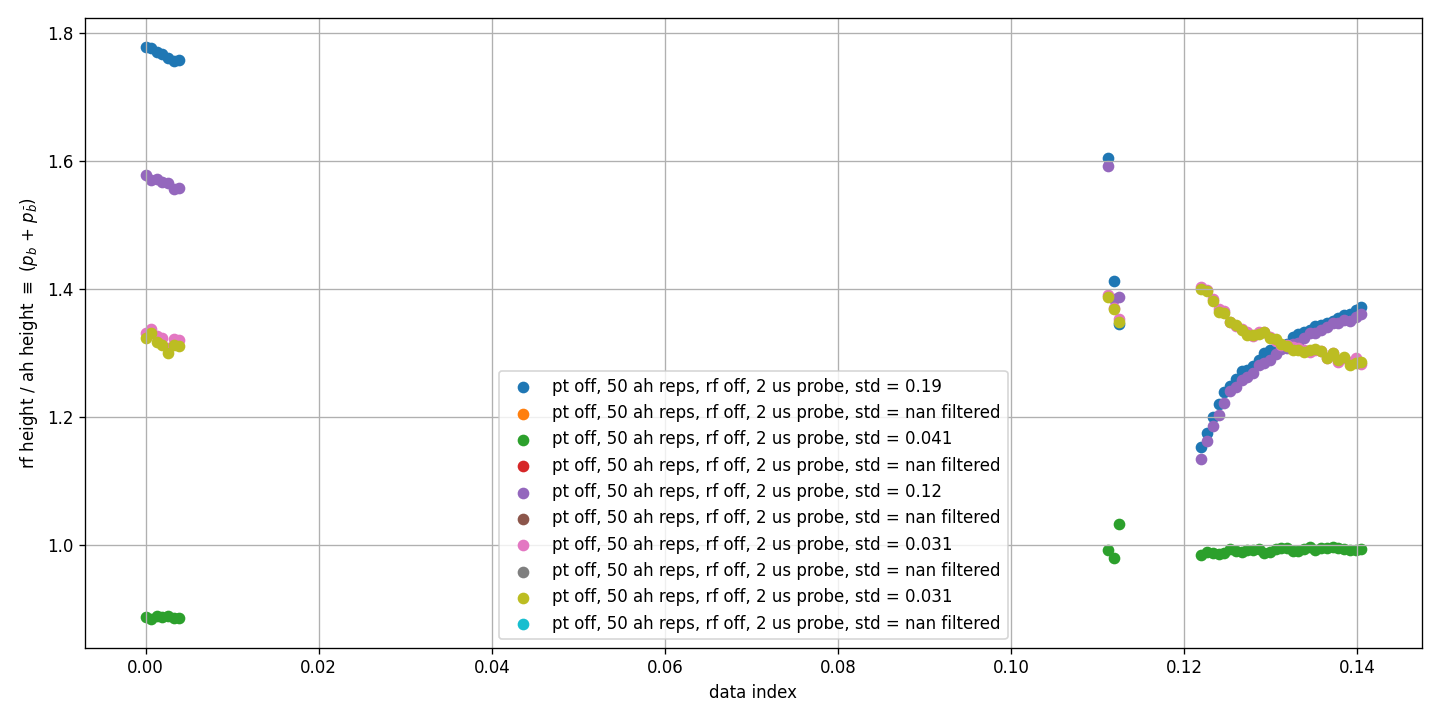

In [64]:
data = {
    # "1": (166056, 166082),
    # "2": (166083, 166101),
    # "3": (166104, 166124),
    # "4": (166125, 166136),
    # "5": (166137, 166145),
    # "6": (166146, 166161),
    # "7": (166162, 166178),
    # "8": (166179, 166201),
    # "9": (166204, 166217),
    # "10": (166221, 166258),
    # "11": (166268, 166292),
    # "12": (166293, 166307),
    # "13": (166308, 166318),
    # "14": (166325, 166403),
    # "15": (166408, 166416),
    # "16": (166423, 166432),

    # "ah 8 reps": (166696, 166747),
    # "ah 20 reps": (166748, 166801),
    # "ah 50 reps": (166802, 166824),
    # "ah 8 reps + 500 ms wait after ah": (166825, 166884),
    # "ah 8 reps + 500 ms wait after chasm": (166914, 166975),
    # "ah 8 reps again": (166976, 167020),
    # "ah 50 reps again": (167021, 167054),
    # "ah 50 reps, no inten. stab.": (167055, 167084),

    #"8 reps, 3usx32": (167366, 167637),
    #"8 reps, 50usx1": (167638, 167933),
    #"8 reps, 5usx16": (167934, 168008),
    #"8 reps, 10usx8": (168009, 168084),
    #"8 reps, 10usx4, scan": (168085, 168210),
    # "32 MHz LPF": (170900, 171429),
    # "11 MHz LPF": (171900, 172429),
    # "11 MHz LPF 2": (172430, 172440),
    #"11 MHz LPF overnight": (173250, 192429),
    #"pt on": (196850, 196949),
    #"pt off": (197020, 197049),
    #"pt off, 50 ah reps": (197070, 197090),
    #"pt off, 50 ah reps, rf on": (197230, 197245),
    "pt off, 50 ah reps, rf off, 2 us probe": (197250, 197288),
}
def get_mask(array_to_mask, xs_mask, ys_mask, limit = 1.65):
    if label == "32 MHz LPF":
        mask = ys_mask < 1.99
        mask2 = ys_mask > 1.87
    else:
        mask = ys_mask < 5
        mask2 = ys_mask > 1.85
    mask = np.bitwise_and(mask, mask2) 
    xs2 = xs[mask]
    as2 = array_to_mask[mask]
    ax.scatter(xs2, as2, label=label + f", std = {np.std(as2):.2g} filtered")
    return xs2, as2
    
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    #xs = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
    # xs = np.array([header["data_info"]["data_number"] for header in headers])
    xs = np.array([header["data_info"]["save_epoch_time"] for header in headers])
    xs = (xs - np.min(xs))/3600
        
    # ys = rf_bgs[0] / ah_bgs[0]
    # ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    # ys = rf_bgs[0] * (1 - rf_heights[0]) / (ah_bgs[0] * (1 - ah_heights[0]))
    # ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")

    ys = np.abs(ah_heights[0]) * 14
    ys_to_mask = ys
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = np.array(rf_heights[0] / (ah_heights[0]))
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = np.abs(rf_heights[0]) * 14
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = ah_bgs[0]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
    ys = rf_bgs[0]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    get_mask(ys, xs, ys_to_mask)
    
#ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_xlabel("data index")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

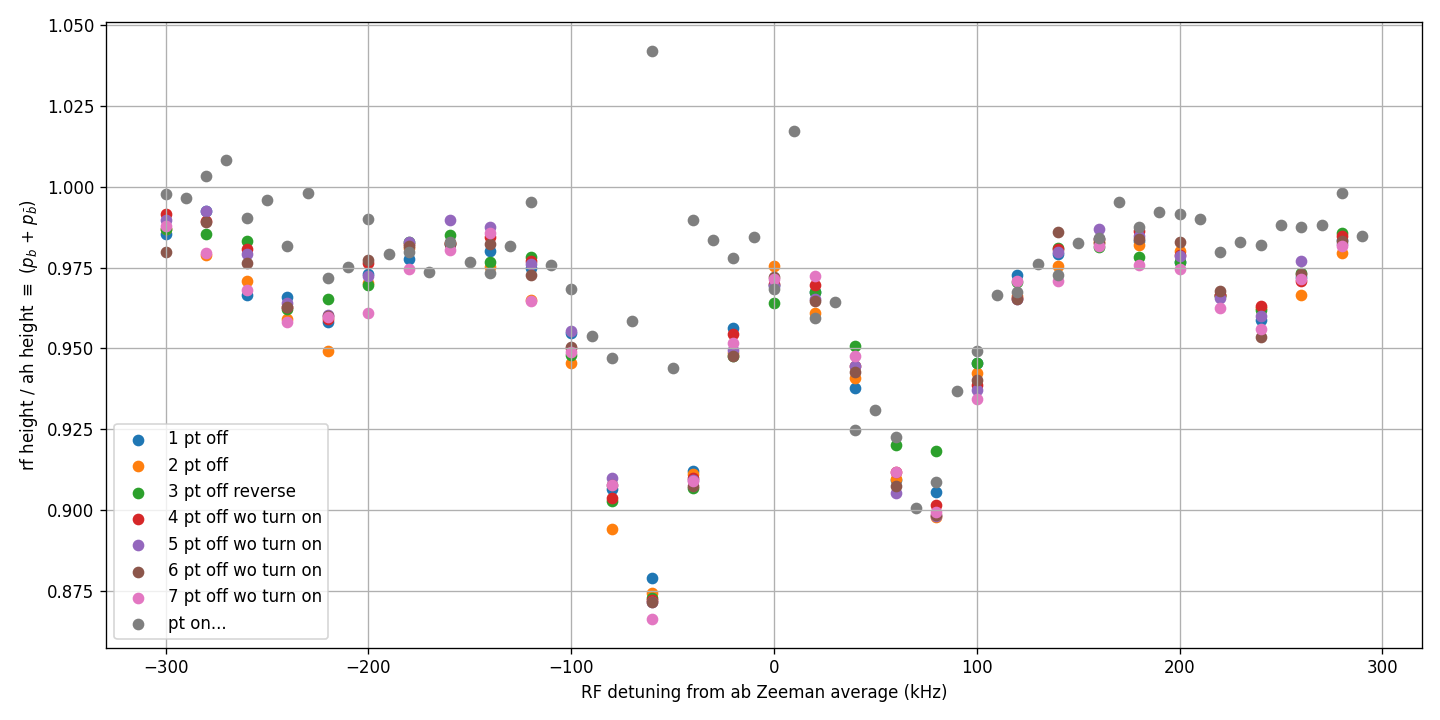

In [65]:
data = {
    #"spec": (166565, 166604),
    #"spec1": (166605, 166607),
    # "after thermalization": (167284, 167323),
    # "reverse freq order": (167324, 167363),

    #--
    # "1 pt on": (195130, 195159),
    # "2 pt on": (195160, 195189),
    "1 pt off": (195190, 195219),
    "2 pt off": (195220, 195249),
    # "3 pt on": (195250, 195279),
    # "4 pt on": (195280, 195309),
    "3 pt off reverse": (195310, 195339),
    "4 pt off wo turn on": (195340, 195369),
    "5 pt off wo turn on": (195370, 195399),
    "6 pt off wo turn on": (195400, 195429),
    "7 pt off wo turn on": (195430, 195459),
    # "8 pt off wo turn on": (195460, 195489),
    # "9 pt off wo turn on": (195490, 195519),
    "pt on...": (195686, 195745),

}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)
    
ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

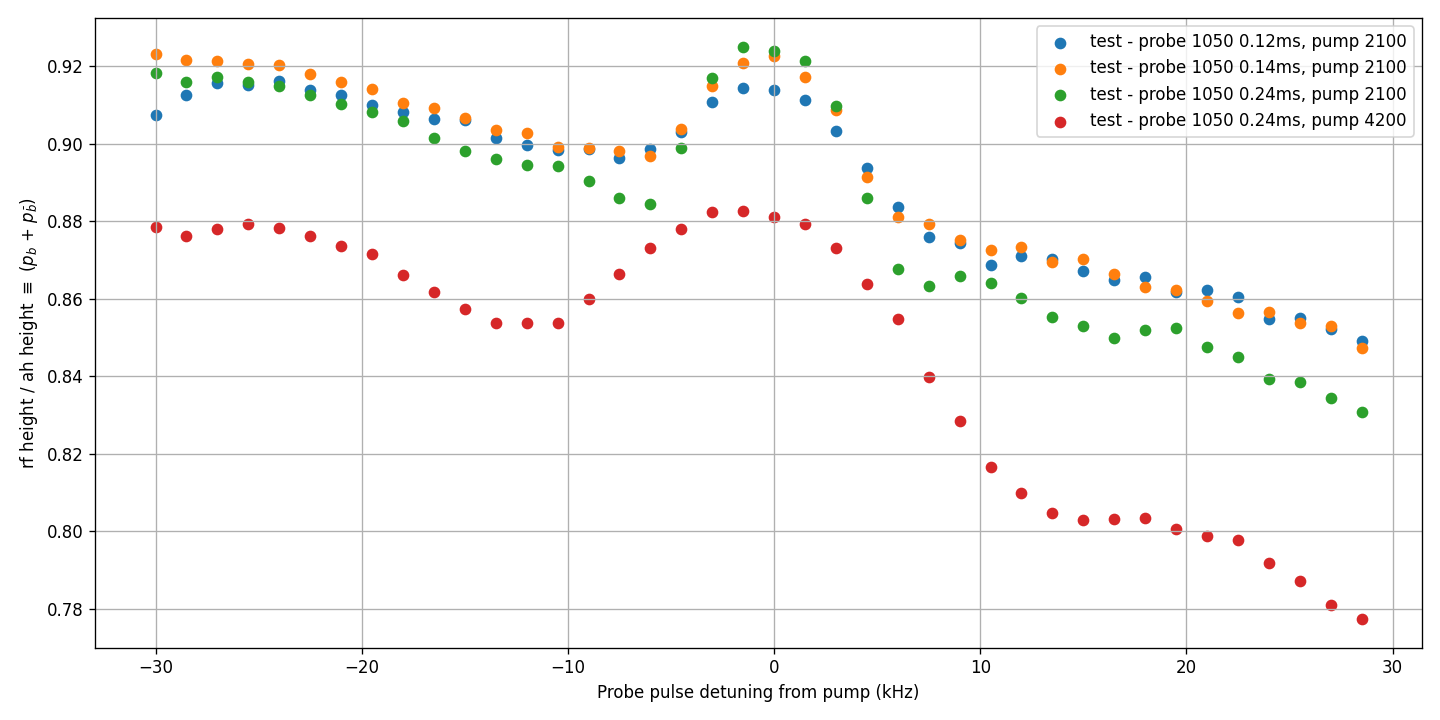

In [66]:
data = {
    # "pt off test - 2100 amplitude": (195770, 195777),
    # "pt off":(195758, 195769),
    # "pt on 2":(195778, 195787),
    # "pt on 3": (195833, 195846),
    # "pt on 4": (195863, 195876),
    # "pt on 5": (195917, 195930),
    # "pt off": (195942, 195981),
    # "pt on 2": (196104, 196119),
    # "pt on 6": (196120, 196135),
    # "pt on 6": (196140, 196183),
    # "pt off 7": (196186, 196205),
    # "pt off 8": (196206, 196225),
    # "pt off 9": (196239, 196246),
    # "pt on": (197611, 203610),
    # "pt off": (196249, 196848),
    "test - probe 1050 0.12ms, pump 2100": (203713, 203752),
    "test - probe 1050 0.14ms, pump 2100": (203753, 203792),
    # "test - probe 1050 0.20ms": (203793, 203832),
    "test - probe 1050 0.24ms, pump 2100": (203833, 203872),
    "test - probe 1050 0.24ms, pump 4200": (203873, 203912),
    
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["probe_detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)
    
# ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_xlabel("Probe pulse detuning from pump (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

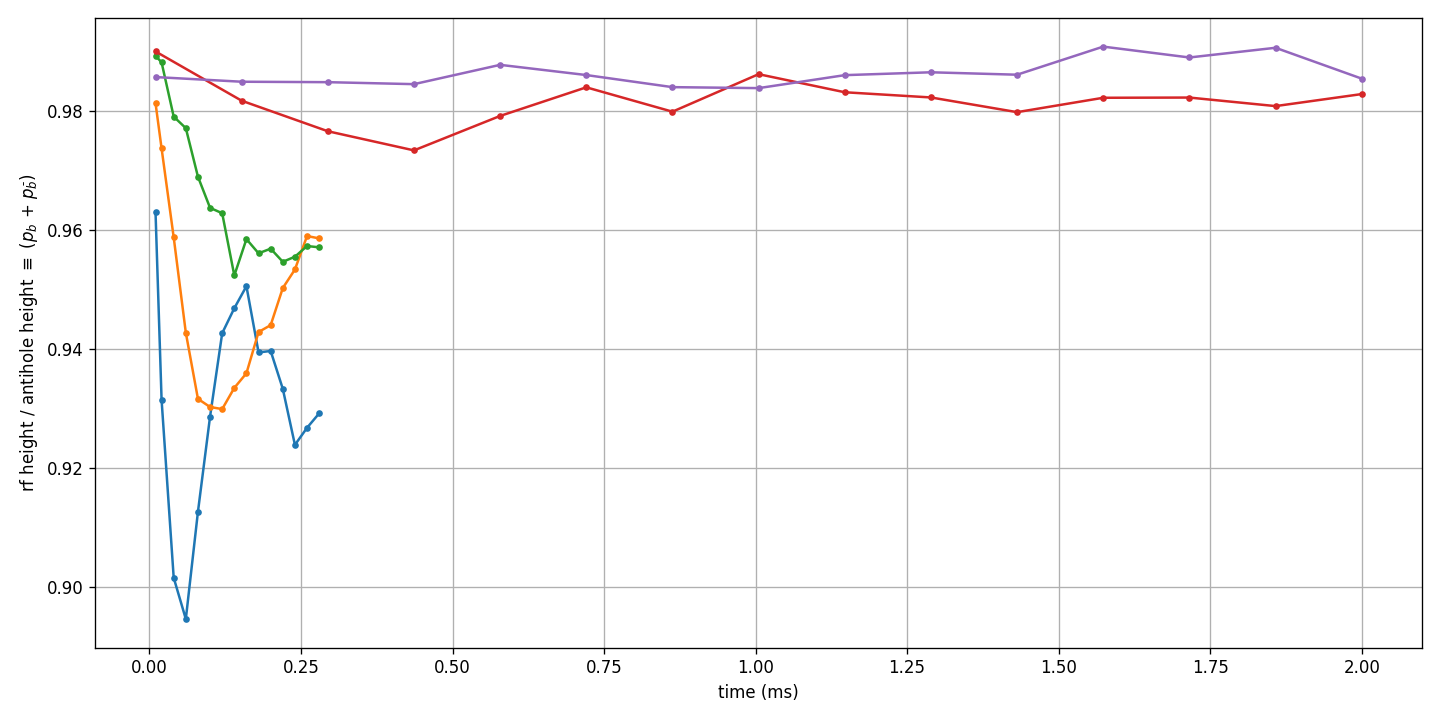

In [67]:
data = {
    # "-70 kHz, 4200": (166505, 166524),
    # "70 kHz, 4200": (166525, 166544),
    # "70 kHz, 4200, 4x": (166545, 166564),
    # "0 amplitude 1": (167183, 167202),
    # "0 amplitude 2": (167203, 167222),
    # "-70 kHz, 4200, 4, 4": (167223, 167242),
    # "-70 kHz, 4200, 20, 1": (167243, 167262),
    # "-70 kHz, 4200, 20, 4": (167263, 167282),

    #---

    "pt off 4200": (195524, 195538),
    "kept pt off 2100": (195539, 195553),
    "kept pt off 1050": (195554, 195568),
    # "PT ON 4200": (195569, 195583),
    # "pt on 2100": (195584, 195598),
    # "pt on 500": (195983, 195997),
    "pt off 500": (196002, 196016),
    "pt off 250": (196032, 196046),





}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["duration"].to("ms").magnitude for header in headers]
    #xs = [header["data_info"]["data_number"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.plot(xs, ys, '.-', label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)

ax.set_xlabel("time (ms)")
#ax.set_xlabel("data index")
ax.set_ylabel("rf height / antihole height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
# ax.legend()
ax.grid()
plt.tight_layout()
plt.show()
fig.canvas.draw()

In [74]:
data, headers = get_experiment_data(203917)

In [75]:
detunings_MHz = headers["detunings"].to("MHz").magnitude
transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])

TypeError: The number of func parameters=5 must not exceed the number of data points=4

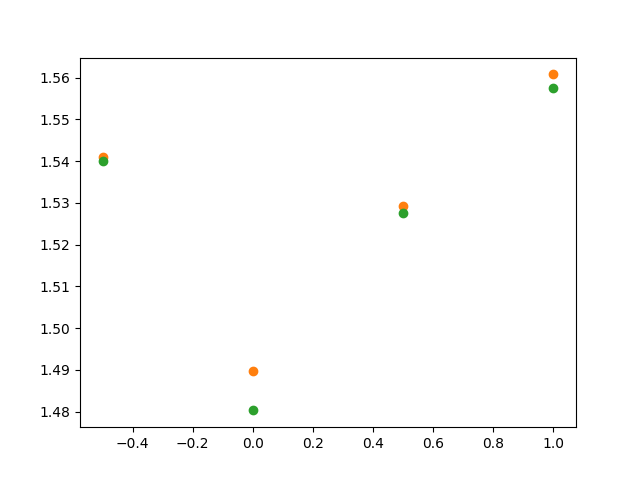

In [77]:
plt_monitor = False
use_positive = None

antihole_avg = transmissions_avg["antihole"]
rf_avg = transmissions_avg["rf"]
if "chasm" in transmissions_avg:
    chasm_avg = transmissions_avg["chasm"]
    antihole_normalized = antihole_avg / chasm_avg
    rf_normalized = rf_avg / chasm_avg
else:
    chasm_avg = None
    antihole_normalized = antihole_avg
    rf_normalized = rf_avg

if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
ax.scatter(detunings_MHz[mask], antihole_normalized, label="antihole", color="C1")
ax.scatter(detunings_MHz[mask], rf_normalized, label="rf", color="C2")

xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
#antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001, "sigma": 0.005, "a": 0.01, "c": 0.011})
#ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "hole fit", color="C1")
#rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
#ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.legend()
plt.tight_layout()
plt.show()

#print(antihole_fit.all_results_str())
print()
#print(rf_fit.all_results_str())

0.1342515292702997 0.13663296442487505
0.11994857630657918 0.12846181099263132
0.10661079743019874 0.12267009301161869
0.09346732048194639 0.11664213631970732
0.07723708498225068 0.10896275757192708
0.061737019217272704 0.10330911303105528
0.04728419248732152 0.09520452269159063
0.035123422107283364 0.08367565018938616


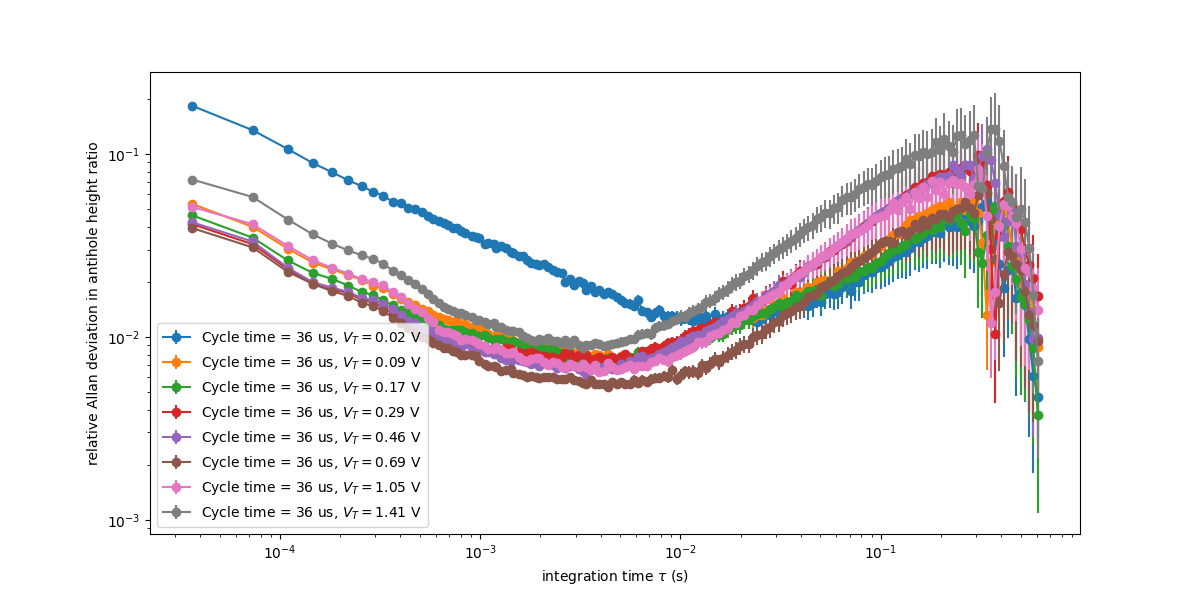

In [17]:
labels = [170298, 170299, 170305, 170300, 170304, 170301, 170303, 170302]
labels = dict([(kk, kk) for kk in labels])

# labels = [170306, 170323, 170325, 170318, 170328, 170327, 170313, 170314]
# labels = dict([(kk, kk) for kk in labels])

fig, ax = plt.subplots(figsize=(12, 6))
for kk, label in enumerate(labels):
    data, headers = get_experiment_data(labels[label])  # 169455 - amp 210, 169456 - amp 160
    cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5).to("s").magnitude) + 24e-6
    cycles = headers["params"]["detect"]["cycles"]["antihole"]
    
    times = np.arange(cycles) * cycle_time
    ah_ratios = data["transmissions_avg"][:cycles,0] / data["transmissions_avg"][:cycles,1]
    rf_ratios = data["transmissions_avg"][cycles:cycles*2,0] / data["transmissions_avg"][cycles:cycles*2,1]
    ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
    print(1- np.average(rf_ratios), 1- np.average(ah_ratios))
    
    fitter = Fitter(lambda x, a, b: a * x + b)
    fitter.set_data(times, ratios)
    fitter.fit()
    ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, ah_ratios)
    fitter.fit()
    ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, rf_ratios)
    fitter.fit()
    rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
    plot_variable = np.copy(ratios_no_bg)
    
    plot_variable /= np.average(plot_variable)
    taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
    real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
    #allan *= np.sqrt(np.average(data["transmissions_avg"]))
    #allan_err *= np.sqrt(np.average(data["transmissions_avg"]))
    real_taus *= cycle_time
    #ax.plot(real_taus, allan[0] / np.sqrt(real_taus / real_taus[0]), color=f"C{kk}", ls="--")
    ax.errorbar(real_taus, allan, allan_err, fmt="o", ls="-", label=f"Cycle time = {cycle_time*1e6:.0f} us" + ", $V_T=" + f"{np.average(data["transmissions_avg"]):.2f}$ V", color=f"C{kk}")
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("integration time $\\tau$ (s)")
ax.set_ylabel("relative Allan deviation in antihole height ratio")
ax.legend()
plt.show()

0.09804690171279029 0.09731132552354349
1.2141371548071838
--
0.13591968178232006 0.13462725122717023
1.284250282255406
--
0.1264188965299573 0.12534541644300734
1.2765583992004395
--
0.13230286382433842 0.13012248906652513
1.253813757299153
--
0.13773822040411277 0.13518134370661483
1.2516479936258968
--
0.13602297781456107 0.13142231995100084
1.3050950017308307
--
0.136127211255213 0.13209800723597842
1.2712604283405622
--
0.12356547436378162 0.12144511134250813
1.2494613688913725
--
0.09969946765901616 0.09843519746784013
1.1913446009177375
--
0.08494590798998258 0.08109589927424887
1.162804479229704
--
0.07477582665378779 0.07431710098388133
0.9163060266021499
--
0.09384779927925557 0.09302223538314547
1.1342881912116718
--


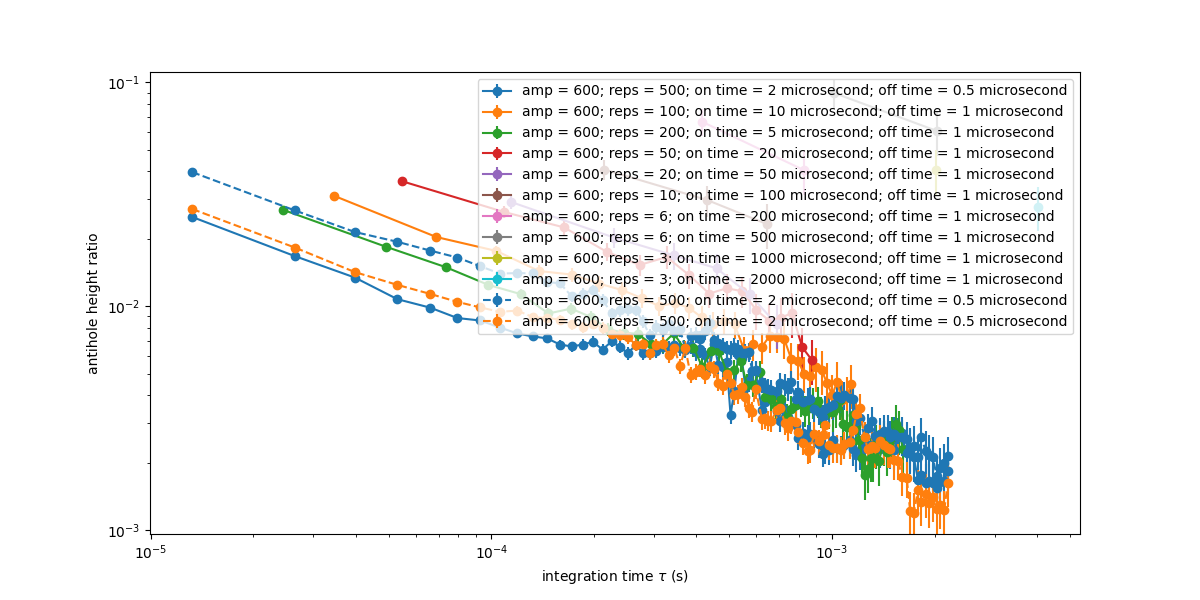

In [31]:
# data, headers = get_experiment_data(170296)
data, headers = get_experiment_data(192435) # 4 K, 380 amplitude
# data, headers = get_experiment_data(192436) 
data, headers = get_experiment_data(192438) # 7 K, 380 amplitude
data, headers = get_experiment_data(192439) # 4 K, 300 amplitude
# # data, headers = get_experiment_data(192440) # 4 K, 300 amplitude
# data, headers = get_experiment_data(192443) # 4 K, 200 amplitude 1000000 detects
# data, headers = get_experiment_data(192444) # 4 K, 200 amplitude 100000 detects
# data, headers = get_experiment_data(192445) # 4 K, 250 amplitude 100000 detects
# data, headers = get_experiment_data(192446) # 4 K, 180 amplitude 100000 detects
# data, headers = get_experiment_data(192447) # 4 K, 220 amplitude 100000 detects
data, headers = get_experiment_data(192448)
data, headers = get_experiment_data(192449)
data, headers = get_experiment_data(192450)
data, headers = get_experiment_data(192451)
data, headers = get_experiment_data(192452)
# data, headers = get_experiment_data(192461)
#192451 - no vibration
#192457 2.8 Hz hammer
#192458 3 Hz hammer
#192459 2 Hz hammer
#192461 - baseline #1
#192462 - baseline #2
#192463 - baseline #3

lines = ["-", "--"]
data_groups = {
    # "baseline": [192461, 192462, 192463, 192464, 192465],
    # "angles removed from optics platform": [192466, 192467, 192468, 192469, 192470, 192471, 192472],
    # "more things loosened up - transmisison pd platform, fridge-platform beam": [192475, 192476, 192477, 192478, 192479, 192480, 192481, 192482, 192483],
    # "changing beam size 1": [192484], # 6 turns CW
    # "changing beam size 2": [192485], # 0 turns CW ao amplitude 220
    # "changing beam size 3, amp 200": [192487], # 3 turns CW, ao amplitude 200
    # "changing beam size 3, amp 220": [192486], # 3 turns CW, ao amplitude 220
    # "changing beam size 3, amp 230": [192489], # 3 turns CW, ao amplitude 230
    # "changing beam size 3, amp 240": [192488], # 3 turns CW, ao amplitude 240
    # "changing beam size 3, amp 250": [192490], # 3 turns CW, ao amplitude 250
    # "changing beam size 3, amp 260": [192491], # 3 turns CW, ao amplitude 260
    # "changing beam size 3, amp 270": [192492], # 3 turns CW, ao amplitude 270
    # "changing beam size 3, amp 300": [192493], # 3 turns CW, ao amplitude 300
    # "changing beam size 3, amp 320": [192494], # 3 turns CW, ao amplitude 320
    # "changing beam size 3, amp 340": [192495], # 3 turns CW, ao amplitude 320
    # "changing beam size 3, amp 400": [192496], # 3 turns CW, ao amplitude 320
    # "changing beam size 3, amp 500": [192497, 192502, 192503, 192504],
    # "changing beam size 3, amp 600": [192498, 192499, 192500, 192501],
    # "changing beam size 3, amp 650": [192510, 192511, 192512, 192513],
    # "changing beam size 3, amp 700": [192506, 192507, 192508, 192509],
    # "amp 200": [192514, 192515, 192516, 192517, 192518],
    # "amp 300": [192519, 192520, 192521, 192522, 192523],
    # "amp 400": [192524, 192525, 192526, 192527, 192528],
    # "amp 500": [192529, 192530, 192531, 192532, 192533],
    # "amp 600": [192534, 192535, 192536, 192537, 192538],
    # # "amp 700": [192539, 192540, 192541, 192542, 192543],
    # # "amp 800": [192544, 192545, 192546, 192547, 192548],
    # "0": (193225, 193249),
    # "1": (193225, 193274),
    # "2": (193225, 193299),
    # "3": (193225, 193324),
    # "4": (193225, 193349),
    # "5": (193225, 193374),
    # "6": (193225, 193399),
    # "7": (193225, 193424),
    # "8": (193225, 193449),
    # "9": (193225, 193474),
    # "10": (193225, 193499),
    # "11": (193225, 193524),
    # "12": (193225, 193549),
    # "13": (193225, 193574),
    # "14": (193225, 193599),
    # "15": (193225, 193624),
    # "16": (193225, 193649),
    # "17": (193225, 193674),
    # "18": (193225, 193699),
    # "19": (193225, 193724),
    # "20": (193225, 193749),
    # "21": (193225, 193774),
    # "22": (193225, 193799),
    # "23": (193225, 193824),
    # "24": (193225, 193849),
    # "25": (193225, 193874),
    # "26": (193225, 193899),
    # "27": (193225, 193924),
    # "28": (193225, 193949),
    # "29": (193225, 193974),
    # "30": (193225, 193999),
    # "31": (193225, 194024),
    # "32": (193225, 194049),
    # "33": (193225, 194074),
    # "34": (193225, 194099),
    # "35": (193225, 194124),
    # "1": (194127, 194146),
    # "2": (194147, 194166),
    # "3": (194167, 194186),
    # "4": (194187, 194206),
    # # "5": (194207, 194226),
    # # "6": (194227, 194246),
    # # "7": (194247, 194266),
    # # "8": (194267, 194286),
    # "5": (194287, 194386),
    # # "6": (194287, 194291),
    # # "7": (194382, 194386),
    # # "8": (194330, 194334),
    # "9": (194487, 194586),
    # "10": (194587, 194686),
    # "11": (194687, 194786),
    # "12": (194817, 194826),
    #"13": (194917, 194926), # pd oversaturated
    #"14": (194927, 194936), 
    #"19": (194990, 194999), # long eom
    #"20": (195000, 195009), # pt off
    #"21": (195010, 195019), # detunings [0, 2]
    #"22": (195020, 195029), # ah repeats 20
    #"23": (195030, 195039), # no antihole
    #"24": (195040, 195049), # pt off
    #"25": (195050, 195059), # pt on
    #"26": (195060, 195069), # pt off to 500 amp
    #"27": (195070, 195079), #pt off 50:10 on off time
    #"28": (195090, 195099), # pt on bb
    #"29": (195100, 195109), # pt off bb
    #"30": (195110, 195119), # pump off
    #"31": (195120, 195129), # 600 amp
    "32": (197280, 197289), # 2 us on
    "33": (197339, 197348), # 10 us on
    "34": (197359, 197368), # 5 us on
    "35": (197401, 197410), # 20 us on
    "36": (197415, 197424), # 50 us on
    "37": (197447, 197456), # 100 us on
    "38": (197457, 197466), # 200 us on
    "39": (197474, 197483), # 500 us on
    "40": (197515, 197524), # 1000 us on
    "41": (197529, 197538), # 2000 us on
    "42": (197580, 197589), # 2 us on, additional filter
    "43": (197594, 197603), # 2 us on, no additional filter







}#[192451, 192457, 192458, 192459]


first_integration_times = []
on_times = []
allan_first = []
allan_first_errs = []

fig, ax = plt.subplots(figsize=(12, 6))
for ll, (label, data_group) in enumerate(data_groups.items()):
    allans = []
    allan_errs = []
    if isinstance(data_group,(list,np.ndarray)):
        pass
    elif isinstance(data_group, (tuple)):
        data_group = range(data_group[0], data_group[1]+1)
    for kk in data_group:
        data, headers = get_experiment_data(kk)
        transmissions_avg = data["transmissions_avg"]
        fitter = Fitter(lambda x, a, b: a * x + b)
        
        cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5 + headers["params"]["detect"]["delay"]).to("s").magnitude) + 4e-6
        # print(headers["params"]["detect"]["on_time"])
        cycles = headers["params"]["detect"]["cycles"]["antihole"]
        
        factor = 1
        times = np.arange(cycles*factor) * cycle_time
        ah_ratios = transmissions_avg[:cycles*factor,0] / transmissions_avg[:cycles*factor,1]
        rf_ratios = transmissions_avg[cycles*factor:cycles*factor*2,0] / transmissions_avg[cycles*factor:cycles*factor*2,1]
        ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
        fitter.set_data(times, ratios)
        fitter.fit()
        
        # fig, ax = plt.subplots(figsize=(12, 6))
        #ax.plot(times, ratios)
        #ax.plot(times, fitter.fitted_value(times))
        ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, ah_ratios)
        fitter.fit()
        ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, transmissions_avg[:cycles*factor,0])
        fitter.fit()
        ah_on_res_no_bg = transmissions_avg[:cycles*factor,0] - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, transmissions_avg[:cycles*factor,1])
        fitter.fit()
        ah_off_res_no_bg = transmissions_avg[:cycles*factor,1] - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, rf_ratios)
        fitter.fit()
        rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
        
        plot_variable = np.copy(ratios_no_bg)
        #ax.plot(times, plot_variable)
        #ax.plot(times, ah_ratios_no_bg)
        #ax.plot(times, rf_ratios_no_bg)
        # ax.plot(times, ah_on_res_no_bg)
        # ax.plot(times, ah_off_res_no_bg)
        # ax.set_xlabel("time (s)")
        # ax.set_ylabel("transmission (V)")
        
        plot_variable /= np.average(plot_variable)
        # print(np.std(plot_variable))
        taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
        real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
        real_taus *= cycle_time
        allans.append(allan)
        allan_errs.append(allan_err)
        # print(kk)
    print(1- np.average(ah_ratios), 1- np.average(rf_ratios))
    print(np.average(transmissions_avg))
        
    allan2 = np.average(allans, axis=0)
    allan_err2 = np.average(allan_errs, axis=0)/np.sqrt(len(data_group))
    first_integration_times.append(real_taus[0])
    allan_first.append(allan2[0])
    allan_first_errs.append(allan_err2[0])
    on_times.append(headers["params"]["detect"]["on_time"].to("us").magnitude)
    label = f"amp = {headers["params"]["detect"]["ao_amplitude"]}; reps = {headers["params"]["detect"]["cycles"]["antihole"]}; on time = {headers["params"]["detect"]["on_time"]}; off time = {headers["params"]["detect"]["off_time"]}"
    print("--")
    ax.errorbar(real_taus, allan2, allan_err2, fmt="o", ls=lines[ll//10], label=label)
            
    # ax.plot(real_taus, allan2[0] / np.sqrt(real_taus / real_taus[0]), ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("integration time $\\tau$ (s)")
    ax.set_ylabel("antihole height ratio")
plt.legend()
plt.show()



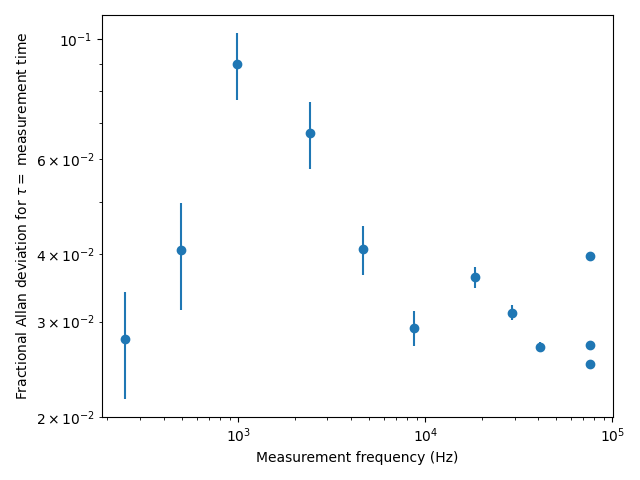

In [32]:
fig, ax = plt.subplots()
ax.errorbar(1 / np.array(first_integration_times), allan_first, allan_first_errs, ls="none", fmt="o")
ax.set_yscale("log")
ax.set_ylabel("Fractional Allan deviation for $\\tau = $ measurement time")
ax.set_xlabel("Measurement frequency (Hz)")
ax.set_xscale("log")
plt.tight_layout()
plt.show()

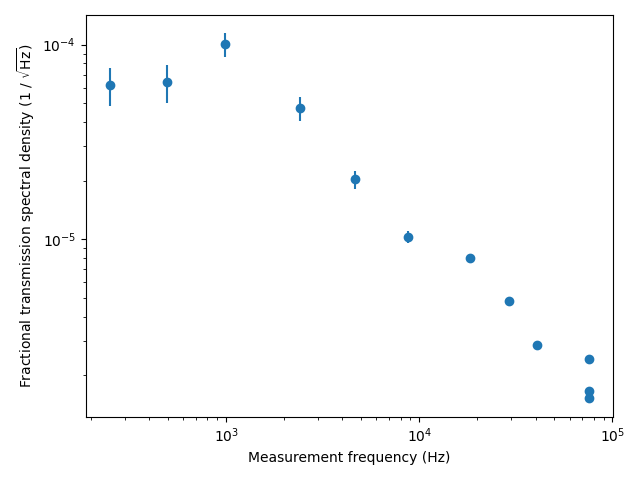

In [33]:
fig, ax = plt.subplots()
factor_antihole_ratio_to_antihole_height = np.sqrt(2)
factor_antihole_height_to_transmission = np.sqrt(2) * 10
total_factor = factor_antihole_ratio_to_antihole_height * factor_antihole_height_to_transmission
ax.errorbar(
    1 / np.array(first_integration_times),
    np.array(allan_first) * np.sqrt(np.array(on_times) * 1e-6 - 0.5e-6) / total_factor,
    np.array(allan_first_errs) * np.sqrt(np.array(on_times) * 1e-6 - 0.5e-6) / total_factor,
    ls="none", fmt="o"
)
ax.set_yscale("log")
ax.set_ylabel("Fractional transmission spectral density (1 / $\\sqrt{\\mathrm{Hz}}$)")
ax.set_xlabel("Measurement frequency (Hz)")
ax.set_xscale("log")
plt.tight_layout()
plt.show()

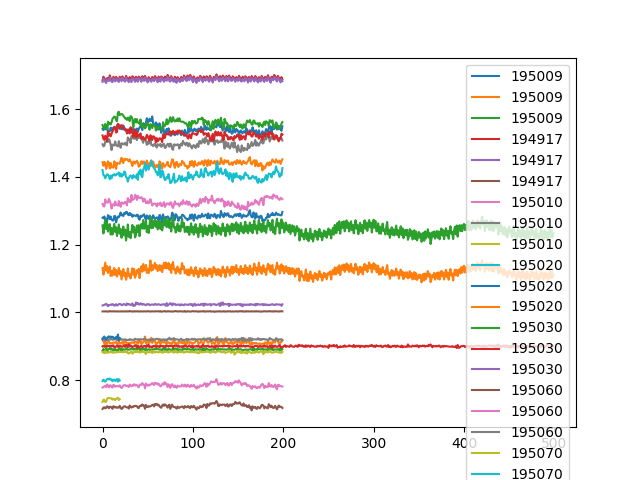

In [377]:
data_numbers = [195009, 194917, 195010, 195020, 195030, 195060, 195070, 197300]


fig, ax = plt.subplots()
for data_number in data_numbers:
    data, headers = get_experiment_data(data_number)
    
    transmissions_avg = data["transmissions_avg"]
    fitter = Fitter(lambda x, a, b: a * x + b)
    
    cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5 + headers["params"]["detect"]["delay"]).to("s").magnitude) + 4e-6
    # print(headers["params"]["detect"]["on_time"])
    cycles = headers["params"]["detect"]["cycles"]["antihole"]
    
    factor = 1
    times = np.arange(cycles*factor) * cycle_time
    ah_ratios = transmissions_avg[:cycles*factor,0] / transmissions_avg[:cycles*factor,1]
    rf_ratios = transmissions_avg[cycles*factor:cycles*factor*2,0] / transmissions_avg[cycles*factor:cycles*factor*2,1]
    ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
    fitter.set_data(times, ratios)
    fitter.fit()
    
    # fig, ax = plt.subplots(figsize=(12, 6))
    #ax.plot(times, ratios)
    #ax.plot(times, fitter.fitted_value(times))
    ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, ah_ratios)
    fitter.fit()
    ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, transmissions_avg[:cycles*factor,0])
    fitter.fit()
    ah_on_res_no_bg = transmissions_avg[:cycles*factor,0] - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, transmissions_avg[:cycles*factor,1])
    fitter.fit()
    ah_off_res_no_bg = transmissions_avg[:cycles*factor,1] - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, rf_ratios)
    fitter.fit()
    rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
    
    ax.plot(transmissions_avg[:cycles*factor,0], label=str(data_number))
    ax.plot(transmissions_avg[:cycles*factor,1], label=str(data_number))
    ax.plot(ah_ratios_no_bg, label=str(data_number))
plt.legend()
plt.show()

In [81]:
data, headers = get_experiment_data(192544)

In [82]:
headers["params"]["detect"]

{'detunings': array([0., 1.]) <Unit('megahertz')>,
 'ao_amplitude': 800,
 'on_time': 5 <Unit('microsecond')>,
 'off_time': 1 <Unit('microsecond')>,
 'cycles': {'chasm': 0, 'antihole': 250, 'rf': 250},
 'delay': 21000 <Unit('microsecond')>,
 'transition': 'bb',
 'trigger_channel': 2,
 'randomize': False}

--


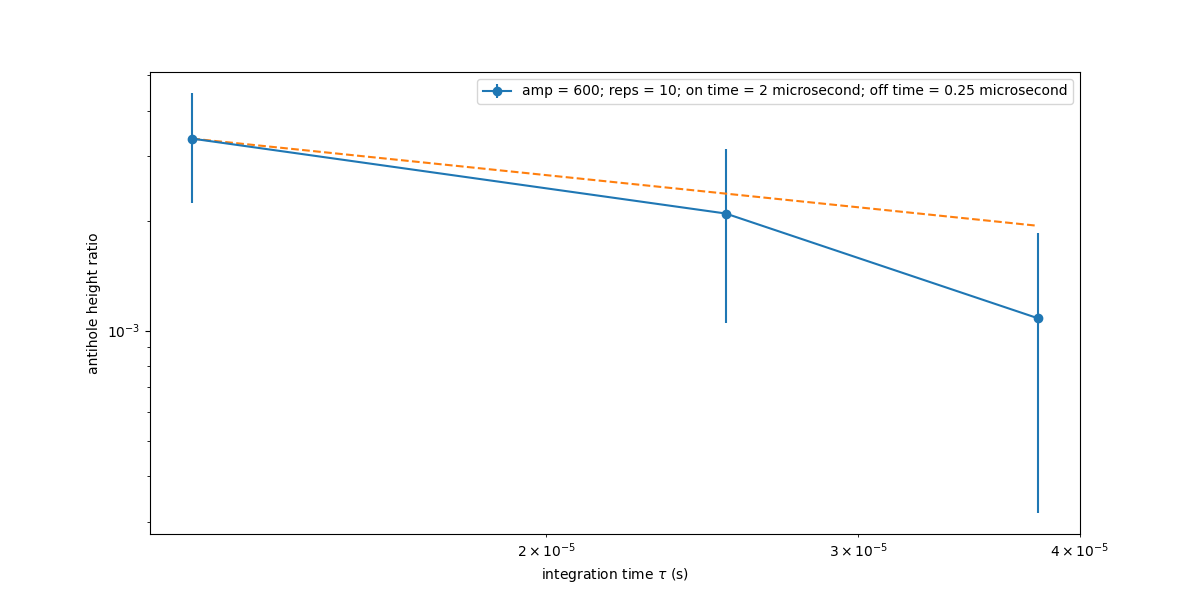

In [105]:
lines = ["-", "--"]
data_groups = {
    # "test": (203923, 203932),
    # "test2": (203943, 203952),
    # "testets": (203963, 203963),
    "": (203965, 203965),

}


first_integration_times = []
on_times = []
allan_first = []
allan_first_errs = []

fig, ax = plt.subplots(figsize=(12, 6))
for ll, (label, data_group) in enumerate(data_groups.items()):
    allans = []
    allan_errs = []
    if isinstance(data_group,(list,np.ndarray)):
        pass
    elif isinstance(data_group, (tuple)):
        data_group = range(data_group[0], data_group[1]+1)
    for kk in data_group:
        data, headers = get_experiment_data(kk)
        transmissions_avg = data["transmissions_avg"]
        fitter = Fitter(lambda x, a, b: a * x + b)
        
        cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5 + headers["params"]["detect"]["delay"]).to("s").magnitude) + 4e-6
        # print(headers["params"]["detect"]["on_time"])
        cycles = headers["params"]["detect"]["cycles"]["antihole"]
        
        factor = 1
        times = np.arange(cycles*factor) * cycle_time
        ah_ratios = transmissions_avg[:cycles*factor,2] - transmissions_avg[:cycles*factor,0]
        rf_ratios = transmissions_avg[cycles*factor:cycles*factor*2,2] - transmissions_avg[cycles*factor:cycles*factor*2,0]
        ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
        fitter.set_data(times, ratios)
        fitter.fit()
        
        # fig, ax = plt.subplots(figsize=(12, 6))
        #ax.plot(times, ratios)
        #ax.plot(times, fitter.fitted_value(times))
        ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, ah_ratios)
        fitter.fit()
        ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, transmissions_avg[:cycles*factor,0])
        fitter.fit()
        ah_on_res_no_bg = transmissions_avg[:cycles*factor,0] - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, transmissions_avg[:cycles*factor,1])
        fitter.fit()
        ah_off_res_no_bg = transmissions_avg[:cycles*factor,1] - fitter.fitted_value(times) + fitter.results["b"]
        fitter.set_data(times, rf_ratios)
        fitter.fit()
        rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
        
        plot_variable = np.copy(ratios_no_bg)
        #ax.plot(times, plot_variable)
        #ax.plot(times, ah_ratios_no_bg)
        #ax.plot(times, rf_ratios_no_bg)
        # ax.plot(times, ah_on_res_no_bg)
        # ax.plot(times, ah_off_res_no_bg)
        # ax.set_xlabel("time (s)")
        # ax.set_ylabel("transmission (V)")
        
        plot_variable /= np.average(plot_variable)
        # print(np.std(plot_variable))
        taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
        real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
        real_taus *= cycle_time
        allans.append(allan)
        allan_errs.append(allan_err)
        
    allan2 = np.average(allans, axis=0)
    allan_err2 = np.average(allan_errs, axis=0)/np.sqrt(len(data_group))
    first_integration_times.append(real_taus[0])
    allan_first.append(allan2[0])
    allan_first_errs.append(allan_err2[0])
    on_times.append(headers["params"]["detect"]["on_time"].to("us").magnitude)
    label = f"amp = {headers["params"]["detect"]["ao_amplitude"]}; reps = {headers["params"]["detect"]["cycles"]["antihole"]}; on time = {headers["params"]["detect"]["on_time"]}; off time = {headers["params"]["detect"]["off_time"]}"
    print("--")
    ax.errorbar(real_taus, allan2, allan_err2, fmt="o", ls=lines[ll//10], label=label)
            
    ax.plot(real_taus, allan2[0] / np.sqrt(real_taus / real_taus[0]), ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("integration time $\\tau$ (s)")
    ax.set_ylabel("antihole height ratio")
plt.legend()
plt.show()



In [103]:
print(np.shape(ah_ratios))

(10,)


In [94]:
transmissions_avg

array([[1.59959653, 1.55195698, 1.61577544, 1.55394666],
       [1.56418971, 1.51384534, 1.57749155, 1.50689487],
       [1.56764623, 1.5195698 , 1.58448585, 1.51732557],
       [1.58030299, 1.5306782 , 1.59511587, 1.53125   ],
       [1.58891859, 1.53958933, 1.60546215, 1.54322973],
       [1.59809313, 1.54864181, 1.61568966, 1.55509159],
       [1.56179328, 1.5150532 , 1.57708905, 1.50761887],
       [1.56837865, 1.52496017, 1.58734956, 1.51813376],
       [1.58133095, 1.53381348, 1.59605944, 1.53143521],
       [1.5898566 , 1.53895328, 1.6060956 , 1.54249731],
       [1.59888338, 1.54670153, 1.60870856, 1.55198512],
       [1.56102231, 1.5170256 , 1.57592114, 1.5021215 ],
       [1.57281815, 1.52583393, 1.58767948, 1.51680361],
       [1.58099044, 1.53031841, 1.59491792, 1.52800882],
       [1.58693334, 1.54010973, 1.60255886, 1.54196693],
       [1.59897332, 1.5488217 , 1.61128194, 1.55259126],
       [1.56166478, 1.51311935, 1.57619827, 1.50438611],
       [1.572362  , 1.52291067,

In [95]:
np.shape(transmissions_avg)

(20, 4)